# TP 5 Regression logistique avec régularisation 
Dans ce TP, nous aimerions faire une classification binaire en utilisant la régression.

Pour ce faire, nous étudierons un ensemble de données avec la variable  (y) representant la commercialisation d'un produit et les caractéristiques (X) representant les résultat des tests de qualité test 1 et test 2 du produit.

La prédiction se fera avec l'agorithme de descente du gradient avec régularisation.

# Importation des librairies necessaires au travail

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
import pandas as pd
import time
from mpl_toolkits.mplot3d import Axes3D

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [68]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(118, 3)

Dans ces données (data), la première colonne represente la première note, la deuxieme colonne la deuxième note et la troisième colonne represente la commercialisation (1 oui 0 non).

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [69]:
# ------------------------------------------------------------------------decouper le dataset en train, validation et test---------------------------------------------------
# Mélanger les données (important pour que ce soit aléatoire)
np.random.seed(42)  # Pour reproductibilité
np.random.shuffle(data)

# Déterminer les tailles
total_size = data.shape[0]
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Découper
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Séparer X et y pour chaque ensemble
X = train_data[:, :-1]
y = train_data[:, -1].reshape(-1, 1)

X_val = val_data[:, :-1]
y_val = val_data[:, -1].reshape(-1, 1)

X_test = test_data[:, :-1]
y_test = test_data[:, -1].reshape(-1, 1)

# Affichage des shapes pour vérification
print("X :", X.shape)
print("y :", y.shape)
print("X_val :", X_val.shape)
print("y_val :", y_val.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

X : (70, 2)
y : (70, 1)
X_val : (23, 2)
y_val : (23, 1)
X_test : (25, 2)
y_test : (25, 1)


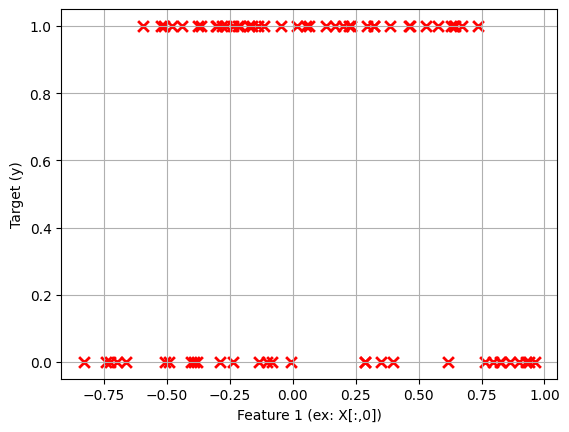

In [70]:

# Affichage des points d'entraînement uniquement (comme dans l'exemple)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Scatter plot : X[:, 0] contre y (si X a plusieurs colonnes)
ax.scatter(X[:, 0], y, s=60, marker='x', color='r', linewidths=2)

plt.xlabel('Feature 1 (ex: X[:,0])')
plt.ylabel('Target (y)')
plt.title('')
plt.grid(True)
plt.show()

# Transformation de données
Dans cette partie, nous aimerions transformer nos données afin d'avoir une fonction polynomiale de degrée 6.

La fonction sera:

$x_0=1$

$x_1=x_1$

$x_2=x_2$

$x_3={x_1}^2$

$x_4={x_1}x_2$

$x_5={x_2}^2$

$x_6={x_1}^3$

$x_7={x_1}^2 x_2$

$x_8= x_1 {x_2}^2$

$x_9= {x_2}^3$

...


Pour un polynme de degrée 6 à 2 variables nous aurons 28 caracteristiques

**Question**: comment avons nous trouvé ce chiffre?

**Astuce**: référez vous aux probabilités

Reponse: On a 28 caractéristiques dans un polynôme de degré 6 à deux variables car il existe 28 combinaisons possibles (avec répétition) de x1x1​ et x2x2​ dont le degré total est inférieur ou égal à 6.

In [71]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,0:2]))
y = data[:, 2]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

print('X', X.shape ,' y ', y.shape)

def normalize_features(X):
    """Normaliser les caractéristiques"""
    mu = np.mean(X[:, 1:], axis=0)  # Moyenne de chaque caractéristique
    sigma = np.std(X[:, 1:], axis=0)  # Écart-type
    X_norm = X.copy()
    X_norm[:, 1:] = (X[:, 1:] - mu) / sigma
    return X_norm, mu, sigma

X_norm, mu, sigma = normalize_features(X)

def mapping(X):
    cols = 28
    degree = 7
    outX = np.ones((X.shape[0], cols))
    
    # X doit contenir le terme d'interception (colonne de 1) et les 2 caractéristiques
    X1 = X[:, 1]  # Première caractéristique (test1)
    X2 = X[:, 2] if X.shape[1] > 2 else X[:, 1]  # Deuxième caractéristique (test2)
    
    k = 0
    for i in range(degree):
        for j in range(i+1):
            outX[:, k] = np.power(X1, i-j) * np.power(X2, j)
            k += 1
    return outX

X2=mapping(X_norm)
X2.shape
X3=mapping(X)
X3.shape





X (118, 3)  y  (118, 1)


(118, 28)

In [72]:
X2=mapping(X_norm) #X2 est normalisé
X2.shape
X3=mapping(X) #X3 n'est pas normalisé
X3.shape

(118, 28)

# Descente du Gradient : Préparation des fonctions

0- Fonction mpgistique (Sigmoid)

In [73]:
def Sigmoid(z):#--------------------------------------------------------------------------------------------------------------------------
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    """
    Calcule la fonction sigmoïde de l'entrée z.

    Paramètre :
    - z : un scalaire, un vecteur ou une matrice (valeurs réelles)

    Retourne :
    - La transformation sigmoïde de z, avec des valeurs entre 0 et 1
    """
    return 1/(1+np.exp(-z))

1- Calcul du coût

Cette fonction servira à calculer le cout $J(\theta_0,\theta_1)$

$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \Theta_j^2$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\Theta_j$ for $j\geq 1$

Elle prendra l'ensemble de données d'apprentissage en entrée ainsi que les paramètres définis initialement

In [74]:
def computeCostReg(X, y, theta, lambda_):#---------------------------------------------------------------------------------------------
    """
    Calcule le coût (J) pour la régression logistique régularisée.

    Paramètres :
    - X : matrice des caractéristiques (m exemples, n caractéristiques)
    - y : vecteur des étiquettes (m x 1)
    - theta : vecteur des paramètres (n x 1)
    - lambda_ : paramètre de régularisation
    - la regularistaion sert à éviter le sur-apprentissage (overfitting)

    Retour :
    - J : coût régularisé (valeur scalaire)
    """
    m = y.shape[0]  # nombre d'exemples

    # Hypothèses (probabilités prédites)
    h = 1 / (1 + np.exp(-X.dot(theta)))  # = Sigmoid(X @ theta)

    # Coût sans régularisation
    cost = (-1/m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))

    # Régularisation (on exclut theta[0])
    reg = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))

    # Coût total
    J = cost + reg

    return J.item()  # .item() pour retourner un scalaire propre



2- Fonction de la descente du gradient

Cette fonction mettra à jour les paramètres $\theta_0,\theta_1$ jusqu'à convergence: atteinte du nombre d'itérations max, ou dérivée assez petite.

In [75]:
def gradientDescent(X, y, theta, alpha, iterations, lambda_):#-----------------------------------------------------------------
    # garder aussi le cout à chaque itération 
    # pour afficher le coût en fonction de theta0 et theta1
    """
    Effectue la descente du gradient pour la régression logistique régularisée.

    Paramètres :
    - X : matrice des caractéristiques (m x n)
    - y : vecteur des étiquettes (m x 1)
    - theta : vecteur des paramètres (n x 1)
    - alpha : taux d’apprentissage
    - iterations : nombre d’itérations à effectuer
    - lambda_ : paramètre de régularisation

    Retour :
    - theta : paramètres optimisés
    - J_history : liste des coûts à chaque itération (pour visualisation)
    """
    m = y.shape[0]
    J_history = []

    for i in range(iterations):
        h = 1 / (1 + np.exp(-X.dot(theta)))  # prédictions

        # Erreur
        error = h - y

        # Gradient
        gradient = (1/m) * X.T.dot(error)
        # Régularisation (on ne régularise pas theta[0])
        reg = (lambda_/m) * theta
        reg[0] = 0  # pas de régularisation pour le biais

        # Mise à jour de theta
        theta = theta - alpha * (gradient + reg)

        # Sauvegarde du coût pour analyse
        cost = computeCostReg(X, y, theta, lambda_)
        J_history.append(cost)

    return theta, J_history



In [76]:
def learning_curve(X_train, y_train, X_val, y_val, lambda_):
    """
    Génère la courbe d'apprentissage (erreur sur train et validation en fonction de la taille du set d'entraînement).
    """
    m = X_train.shape[0]
    train_error = []
    val_error = []
    
    for i in range(1, m, 10):  # Par pas de 10 pour accélérer
        theta_temp = np.zeros((X_train.shape[1], 1))
        theta_temp, _ = gradientDescent(X_train[:i], y_train[:i], theta_temp, alpha, 50, lambda_)
        
        # Erreur d'entraînement
        train_cost = computeCostReg(X_train[:i], y_train[:i], theta_temp, 0)  # Sans régularisation pour l'erreur
        train_error.append(train_cost)
        
        # Erreur de validation
        val_cost = computeCostReg(X_val, y_val, theta_temp, 0)  # Sans régularisation
        val_error.append(val_cost)
    
    plt.figure()
    plt.plot(range(1, m, 10), train_error, label="Train")
    plt.plot(range(1, m, 10), val_error, label="Validation")
    plt.xlabel("Nombre d'exemples d'entraînement")
    plt.ylabel("Erreur")
    plt.title("Courbe d'apprentissage")
    plt.legend()
    plt.grid(True)
    plt.show()

In [77]:
def cross_validate(X, y, alpha_list, lambda_list, n_splits=5, iterations=300):
    """
    Effectue une cross-validation pour trouver les meilleurs hyperparamètres.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []
    
    for alpha in alpha_list:
        for lambda_val in lambda_list:
            fold_accuracies = []
            
            for train_idx, val_idx in kf.split(X):
                # Séparation train/validation
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                # Entraînement
                theta = np.zeros((X.shape[1], 1))
                theta, _ = gradientDescent(X_train, y_train, theta, alpha, iterations, lambda_val)
                
                # Évaluation
                val_pred = predict(X_val, theta)
                accuracy = np.mean(val_pred == y_val) * 100
                fold_accuracies.append(accuracy)
            
            # Stockage des résultats
            avg_accuracy = np.mean(fold_accuracies)
            results.append({
                'alpha': alpha,
                'lambda': lambda_val,
                'accuracy': avg_accuracy
            })
    
    return pd.DataFrame(results)

# Dessin de la limite de decision (Descision Boundary)
Dans cette partie, nous aimerions dessiner la ligne separatrice d nos données

In [78]:
def drawCircle(X, y, theta):
    """
    Affiche les points et la vraie frontière de décision pour un modèle non linéaire.
    """
    # Affichage des données
    pos = y.ravel() == 1
    neg = y.ravel() == 0
    plt.scatter(X[pos, 1], X[pos, 2], marker='o', label='Classe 1', color='b')
    plt.scatter(X[neg, 1], X[neg, 2], marker='x', label='Classe 0', color='r')

    # Définir une grille de valeurs pour x1 et x2
    u = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    v = np.linspace(X[:, 2].min(), X[:, 2].max(), 100)
    z = np.zeros((len(u), len(v)))

    # Calcul de la valeur de la frontière de décision
    for i in range(len(u)):
        for j in range(len(v)):
            mapped = mapping(np.array([[1, u[i], v[j]]]))  # ajoute le biais + map les features
            z[i, j] = np.dot(mapped, theta)

    # transposer z pour être compatible avec contour
    z = z.T

    # Tracer la frontière de décision h = 0.5 <=> z = 0
    plt.contour(u, v, z, levels=[0], colors='g', linewidths=2)

    plt.xlabel('Test 1 (x1)')
    plt.ylabel('Test 2 (x2)')
    plt.title('Limite de décision avec caractéristiques polynomiales')
    plt.legend()
    plt.grid(True)
    plt.show()


# Classification (Prédiction)
Ici il serait interessant de calculer la prédiction en utilisant un seuil
i.e. si h>seuil alors classe =1 sinon classe = 0

In [79]:
#  Prédit les classes en fonction du seuil donné.----------------------------------------------------------- 
def predict(X, theta, seuil=0.5):
    """
    Prédit les classes en fonction du seuil donné.
    
    Paramètres :
    - X : matrice des caractéristiques (m x n), avec m exemples et n caractéristiques
    - theta : vecteur des paramètres (n x 1)
    - seuil : seuil à partir duquel la classification est effectuée (par défaut 0.5)
    
    Retourne :
    - y_pred : vecteur des prédictions de classe (m x 1), où 1 = classe positive, 0 = classe négative
    """
    # Calcul des prédictions h_theta(x) = sigmoid(X * theta)
    h = Sigmoid(np.dot(X, theta))  # X est de taille (m x n) et theta est de taille (n x 1)
    
    # Appliquer le seuil pour prédire la classe
    y_pred = (h >= seuil).astype(int)  # Si h >= seuil, classe 1, sinon classe 0
    
    return y_pred


# Descente du Gradient : Appel des fonctions

Initialisation de $\theta_0$ et $\theta_1$

In [80]:
#initialisation de theta0 et theta1------------------------------------------
n=X.shape[1]
theta = np.zeros((X2.shape[1], 1))  # donc (28, 1)


utiliser la crossvalidation pour trouver le meilleur lambda et alpha Calculer le cout initial

In [81]:
#calcule du coût initial-------------------------------------------------
lambdaa = 0.002
initialCost=computeCostReg(X2, y, theta, lambdaa)
print('Coût initial :')
print(initialCost)
#appel de la fonction gradientDescent-------------------------------------------------
# paramètres
iterations = 1500
alpha = 0.2

# paramètre de regression
lambdaa = 0.002

# Appel
start_time = time.time()
theta, J_history = gradientDescent(X2, y, theta, alpha, iterations, lambdaa)
end_time = time.time()
execution_time_mm = (end_time - start_time) * 1000
# Affichage du coût final
print("coût finale :", J_history[-1])
print("Temps d'exécution (en ms) :", execution_time_mm)

Coût initial :
0.6931471805599453
coût finale : 0.28858227310129186
Temps d'exécution (en ms) : 791.5053367614746


Précision sur l'ensemble d'entraînement: 86.44%
Précision sur l'ensemble de validation: 86.96%


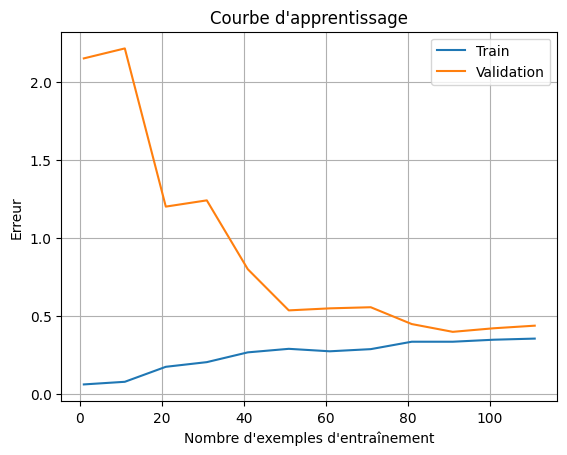

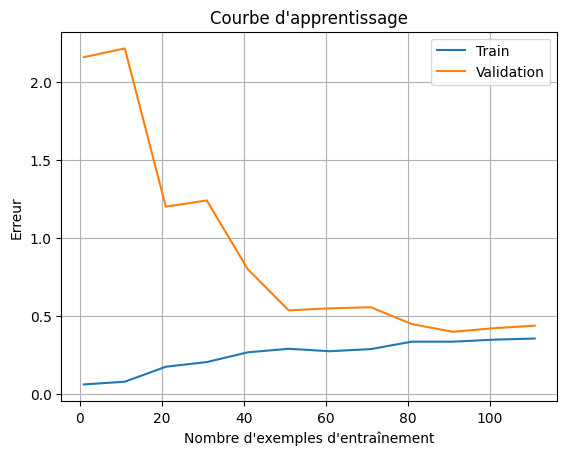

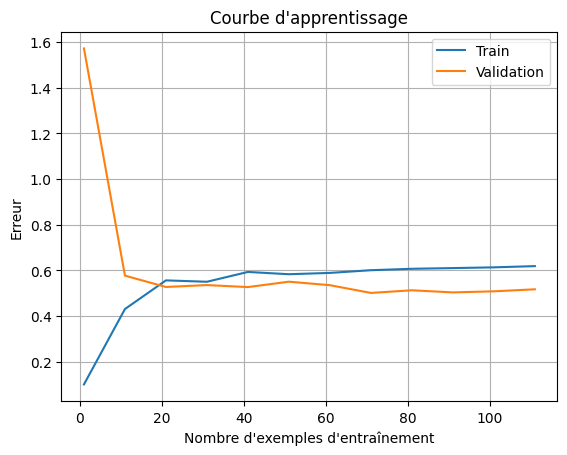

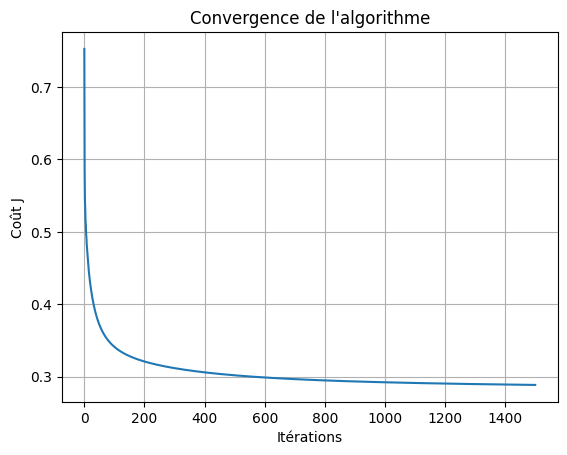

In [82]:
# 1. Précision sur les ensembles train/val/test
train_pred = predict(X2, theta)
train_accuracy = np.mean(train_pred == y) * 100
print(f"Précision sur l'ensemble d'entraînement: {train_accuracy:.2f}%")

# Si vous avez mappé X_val aussi:
def normalize_using_params(X, mu, sigma):
    """Normalise avec les paramètres calculés sur le train set"""
    X_norm = X.copy()
    X_norm[:, 1:] = (X[:, 1:] - mu) / sigma
    return X_norm

# Pour la validation
X_val_with_intercept = np.column_stack((np.ones((X_val.shape[0], 1)), X_val))
X_val_norm = normalize_using_params(X_val_with_intercept, mu, sigma)
X_val_mapped = mapping(X_val_norm)
val_pred = predict(X_val_mapped, theta)
val_accuracy = np.mean(val_pred == y_val) * 100
print(f"Précision sur l'ensemble de validation: {val_accuracy:.2f}%")

# 3. Courbe d'apprentissage
lambda_ = 0
learning_curve(X2, y, X_val_mapped, y_val, lambdaa) #courbe d'apprentissage avec regularisation et normalisation
learning_curve(X2, y, X_val_mapped, y_val, lambda_) #courbe d'apprentissage sans regularisation et avec normalisation
learning_curve(X3, y, X_val_mapped, y_val, lambda_) #courbe d'apprentissage sans regularisation et sans normalisation

# 4. Courbe de convergence (coût vs itérations)
plt.figure()
plt.plot(J_history)
plt.xlabel("Itérations")
plt.ylabel("Coût J")
plt.title("Convergence de l'algorithme")
plt.grid(True)
plt.show()



C:\Users\HERO-INFO\AppData\Local\Temp\ipykernel_8208\4256203518.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i, j] = np.dot(mapped, theta)


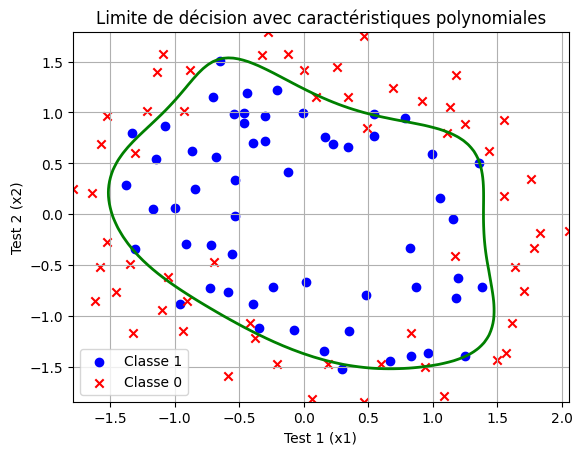

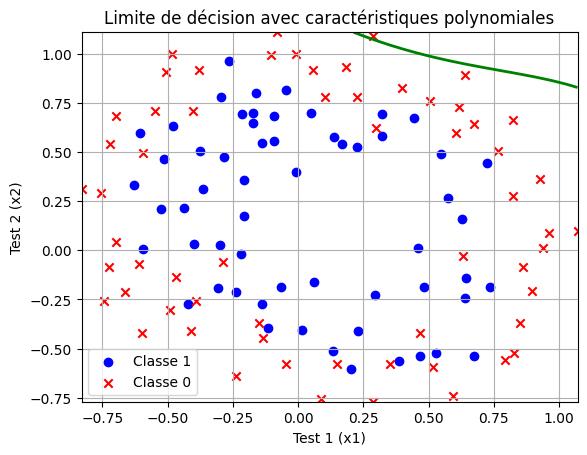

In [83]:
# Appel de drawCircle pour afficher la frontière de décision
drawCircle(X2, y.ravel(), theta) # Affiche la frontière de décision pour le modèle entraîné avec normalisation et mapping
drawCircle(X3, y.ravel(), theta) # Affiche la frontière de décision pour le modèle entraîné sans normalisation



# Affichage 
Graphe representant les acceptations selon les caracteristiques

Text(0, 0.5, 'x 2')

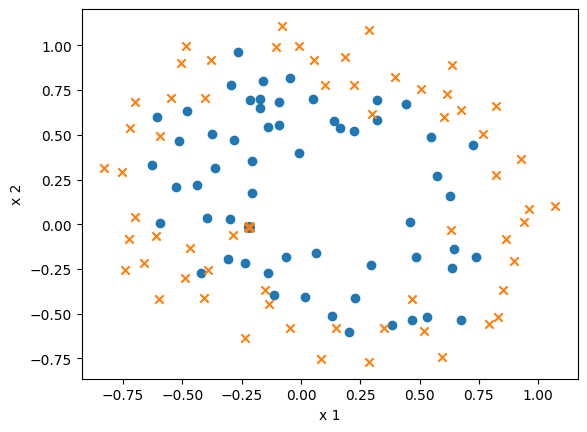

In [84]:
plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="y=1",marker ='o')
plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="y=0",marker ='x')

plt.xlabel('x 1')
plt.ylabel('x 2')

Traçage du coût en fonction de theta0 et theta1

In [85]:
'''''
# tracage du cout en fonction de theta0 et theta1------------------------------------------------------------

# Étape 1 : créer une grille de valeurs pour theta0 et theta1
theta0_vals = np.linspace(-10, 10, 100)
theta1_vals = np.linspace(-10, 10, 100)

# Initialiser la matrice de coût
J_vals = np.zeros((len(theta0_vals), len(theta1_vals)))

# On garde les autres theta fixes (ou à 0 si il y a plus de 2 variables)
# ici on suppose que theta a au moins 3 éléments : theta0, theta1, theta2,...
for i in range(len(theta0_vals)):
    for j in range(len(theta1_vals)):
        t = np.copy(theta)
        t[0] = theta0_vals[i]
        t[1] = theta1_vals[j]
        # les autres thetas restent comme dans l'entraînement
        J_vals[i, j] = computeCostReg(X2, y, t, lambdaa)

# Étape 2 : Tracer la surface 3D
theta0_vals_mesh, theta1_vals_mesh = np.meshgrid(theta0_vals, theta1_vals)

fig = plt.figure(figsize=(12, 5))

# Graphe 3D
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(theta0_vals_mesh, theta1_vals_mesh, J_vals.T, cmap='viridis')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_zlabel('Coût J(θ)')
ax.set_title('Surface du coût')

# Graphe de contour
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contour(theta0_vals, theta1_vals, J_vals.T, levels=np.logspace(-1, 3, 20), cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_xlabel(r'$\theta_0$')
ax2.set_ylabel(r'$\theta_1$')
ax2.set_title('Contours du coût J(θ)')
ax2.plot(theta[0], theta[1], 'rx', markersize=10, label='Minimum')
ax2.legend()

plt.tight_layout()
plt.show()
'''


"''\n# tracage du cout en fonction de theta0 et theta1------------------------------------------------------------\n\n# Étape 1 : créer une grille de valeurs pour theta0 et theta1\ntheta0_vals = np.linspace(-10, 10, 100)\ntheta1_vals = np.linspace(-10, 10, 100)\n\n# Initialiser la matrice de coût\nJ_vals = np.zeros((len(theta0_vals), len(theta1_vals)))\n\n# On garde les autres theta fixes (ou à 0 si il y a plus de 2 variables)\n# ici on suppose que theta a au moins 3 éléments : theta0, theta1, theta2,...\nfor i in range(len(theta0_vals)):\n    for j in range(len(theta1_vals)):\n        t = np.copy(theta)\n        t[0] = theta0_vals[i]\n        t[1] = theta1_vals[j]\n        # les autres thetas restent comme dans l'entraînement\n        J_vals[i, j] = computeCostReg(X2, y, t, lambdaa)\n\n# Étape 2 : Tracer la surface 3D\ntheta0_vals_mesh, theta1_vals_mesh = np.meshgrid(theta0_vals, theta1_vals)\n\nfig = plt.figure(figsize=(12, 5))\n\n# Graphe 3D\nax = fig.add_subplot(1, 2, 1, projection

In [86]:
#------------------------------------------------------------------------------------------
# Prédiction
y_pred = predict(X2, theta)

# Calcul de la précision (pourcentage de bonnes prédictions)
precision = np.mean(y == y_pred) * 100

print(f"Précision du classifieur : {precision:.2f}%")



Précision du classifieur : 86.44%


Précision du classifieur : 86.44%

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn


--- Comparaison ---
Coût initial (mon modèle)      : 0.6931
Coût initial (scikit-learn)    : 0.6931
Coût final  (mon modèle)       : 0.2886
Coût final  (scikit-learn)     : 0.4625
Précision  (mon modèle)        : 86.44%
Précision  (scikit-learn)      : 83.05%
Temps d'exécution (mon modèle) : 791.51 ms
Temps d'exécution (scikit-learn): 9.99 ms


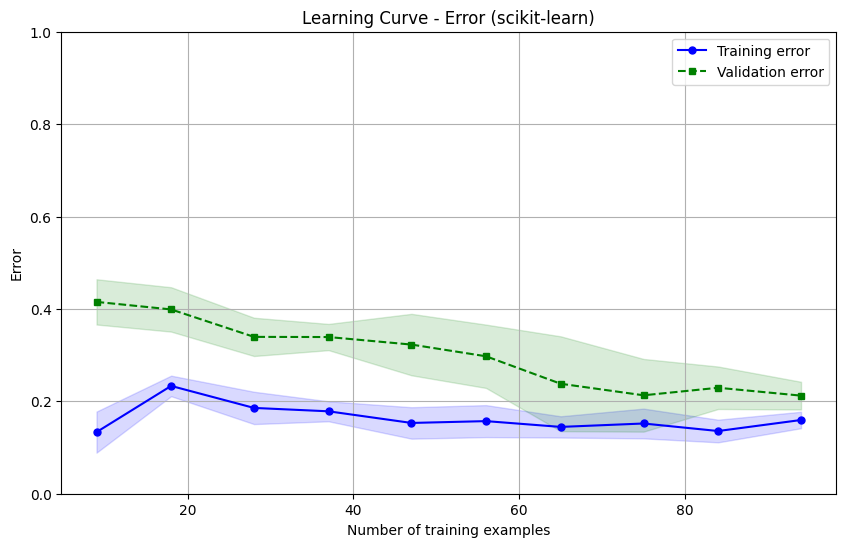

In [87]:
#comparatif avec sklearn====================================================================================================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import learning_curve

# ================================
# 1. Préparation des données (avec mapping comme le tien)
# ================================

X_sklearn = mapping(X)  # On utilise le même mapping que toi
y_sklearn = y.ravel()   # scikit-learn attend un vecteur 1D pour y

# ================================
# 2. Modèle scikit-learn
# ================================

# C = 1/lambda_, donc ici lambda_ = 1 => C = 1.0
start_time_sklearn = time.time()
model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1500)

# Entraînement
model.fit(X_sklearn, y_sklearn)

# Prédictions
y_pred_sklearn = model.predict(X_sklearn)
y_proba_sklearn = model.predict_proba(X_sklearn)[:, 1]

end_time_sklearn = time.time()
execution_time_sklearn_sl = (end_time_sklearn - start_time_sklearn) * 1000
# ================================
# 3. Évaluation
# ================================

# Coût initial (avec theta = 0)
theta_init = np.zeros(X_sklearn.shape[1])
initial_cost_sklearn = log_loss(y_sklearn, 1 / (1 + np.exp(-X_sklearn.dot(theta_init))))

# Coût final
final_cost_sklearn = log_loss(y_sklearn, y_proba_sklearn)

# Précision
accuracy_sklearn = accuracy_score(y_sklearn, y_pred_sklearn) * 100

# ================================
# 4. Affichage comparatif
# ================================

print("\n--- Comparaison ---")
print(f"Coût initial (mon modèle)      : {initialCost:.4f}")
print(f"Coût initial (scikit-learn)    : {initial_cost_sklearn:.4f}")
print(f"Coût final  (mon modèle)       : {J_history[-1]:.4f}")
print(f"Coût final  (scikit-learn)     : {final_cost_sklearn:.4f}")
print(f"Précision  (mon modèle)        : {precision:.2f}%")
print(f"Précision  (scikit-learn)      : {accuracy_sklearn:.2f}%")
print(f"Temps d'exécution (mon modèle) : {execution_time_mm:.2f} ms")
print(f"Temps d'exécution (scikit-learn): {execution_time_sklearn_sl:.2f} ms")




# ================================
# Courbe d'apprentissage scikit-learn
# ================================

from sklearn.model_selection import learning_curve

def plot_learning_curve_sklearn_error(model, X, y):
    """
    Courbe d'apprentissage montrant l'erreur (1 - accuracy)
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Conversion en erreur (1 - accuracy)
    train_error = 1 - np.mean(train_scores, axis=1)
    train_std = np.std(1 - train_scores, axis=1)
    val_error = 1 - np.mean(val_scores, axis=1)
    val_std = np.std(1 - val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_error, color='blue', marker='o', 
             markersize=5, label='Training error')
    plt.fill_between(train_sizes, train_error + train_std,
                     train_error - train_std, alpha=0.15, color='blue')
    
    plt.plot(train_sizes, val_error, color='green', linestyle='--',
             marker='s', markersize=5, label='Validation error')
    plt.fill_between(train_sizes, val_error + val_std,
                     val_error - val_std, alpha=0.15, color='green')
    
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim(0, 1)  # Pour que l'échelle soit entre 0 et 1
    plt.legend()
    plt.grid()
    plt.title('Learning Curve - Error (scikit-learn)')
    plt.show()

# Appel de la fonction
plot_learning_curve_sklearn_error(model, X_sklearn, y_sklearn)



--- Comparaison ---

Coût initial (mon modèle)      : 0.6931 ||
Coût initial (scikit-learn)    : 0.6931

Coût final  (mon modèle)       : 0.28858227310129186 ||
Coût final  (scikit-learn)     : 0.4625

Précision  (mon modèle)        : 86.44% ||
Précision  (scikit-learn)      : 83.05%

Temps d'exécution (mon modèle) : 95.01 ms ||
Temps d'exécution (scikit-learn): 9.18 ms